<a href="https://colab.research.google.com/github/aninda-ghosh/Deep-Learning/blob/master/Traffic_Signal_Analysis_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Let's Import the necessary libraries**

In [ ]:
import matplotlib
matplotlib.use("Agg")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# import the necessary tensorflow packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense


**Let's bring the datasets for analysis**

In [ ]:
train_data = sio.loadmat("/content/drive/MyDrive/Machine Learning/Dataset/trainset.mat")
test_data = sio.loadmat("/content/drive/MyDrive/Machine Learning/Dataset/testset.mat")

image_width = 32
image_height = 32
classes = 43

**Defining CNN Model**

In [ ]:
# initialize the model along with the input shape to be
# "channels last" and the channels dimension itself
model = Sequential()
inputShape = (image_width, image_height, 3) #32x32 pixels of image and 3 for RGB color space
chanDim = -1

# This set of layers uses a 5×5 kernel to learn larger features — 
# it will help to distinguish between different traffic sign shapes and color 
# blobs on the traffic signs themselves.
# CONV => RELU => BN => POOL
model.add(Conv2D(8, (5, 5), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))

# These sets of layers deepen the network by stacking two sets of 
# CONV => RELU => BN layers before applying max-pooling to reduce volume dimensionality.
# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))

# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# second set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# softmax classifier
model.add(Dense(classes))
model.add(Activation("softmax"))

**Images are to be resized and contrast enhanced for better accuracy.**

In [ ]:
#Applying image transform to resize everything into 32x32 pixels and applying CLAHE method to improve the contrast.
no_TrainImages = len(train_data['X'])
for i in range(0,no_TrainImages):
  # check to see if we should show a status update
  if i > 0 and i % 1000 == 0:
    print("[Train INFO] processed {} images / {} total images".format(i, no_TrainImages))
  train_data['X'][i] = transform.resize(train_data['X'][i], (32,32))
  train_data['X'][i] = exposure.equalize_adapthist(train_data['X'][i], clip_limit=0.1)

#Applying image transform to resize everything into 32x32 pixels and applying CLAHE method to improve the contrast.
no_TestImages = len(test_data['X'])
for i in range(0,no_TestImages):
  # check to see if we should show a status update
  if i > 0 and i % 1000 == 0:
    print("[Test INFO] processed {} total images / {} total images".format(i, no_TestImages))
  test_data['X'][i] = transform.resize(test_data['X'][i], (32,32))
  test_data['X'][i] = exposure.equalize_adapthist(test_data['X'][i], clip_limit=0.1)

[Train INFO] processed 1000 images / 39209 total images
[Train INFO] processed 2000 images / 39209 total images
[Train INFO] processed 3000 images / 39209 total images
[Train INFO] processed 4000 images / 39209 total images
[Train INFO] processed 5000 images / 39209 total images
[Train INFO] processed 6000 images / 39209 total images
[Train INFO] processed 7000 images / 39209 total images
[Train INFO] processed 8000 images / 39209 total images
[Train INFO] processed 9000 images / 39209 total images
[Train INFO] processed 10000 images / 39209 total images
[Train INFO] processed 11000 images / 39209 total images
[Train INFO] processed 12000 images / 39209 total images
[Train INFO] processed 13000 images / 39209 total images
[Train INFO] processed 14000 images / 39209 total images
[Train INFO] processed 15000 images / 39209 total images
[Train INFO] processed 16000 images / 39209 total images
[Train INFO] processed 17000 images / 39209 total images
[Train INFO] processed 18000 images / 39

Since we have multiple labels, we have to do one hot encoding for performing the network training

In [ ]:
# one-hot encode the training and testing labels
print(len(np.unique(train_data['Y'])))

numLabels = len(np.unique(train_data['Y']))
train_Y = to_categorical(train_data['Y'], numLabels)
test_Y = to_categorical(test_data['Y'], numLabels)

# calculate the total number of images in each class and
# initialize a dictionary to store the class weights
classTotals = train_Y.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

43
{0: 10.714286, 1: 1.0135136, 2: 1.119403, 3: 1.7045455, 4: 1.0714285, 5: 1.0416666, 6: 2.8846154, 7: 3.5714285, 8: 5.357143, 9: 2.0270271, 10: 1.875, 11: 10.714286, 12: 1.0, 13: 6.25, 14: 6.818182, 15: 5.769231, 16: 4.4117646, 17: 8.333333, 18: 1.5, 19: 3.75, 20: 9.375, 21: 4.1666665, 22: 8.333333, 23: 1.5957447, 24: 5.0, 25: 2.8846154, 26: 9.375, 27: 3.2656024, 28: 5.357143, 29: 1.875, 30: 5.769231, 31: 10.714286, 32: 1.0869565, 33: 7.5, 34: 1.1363636, 35: 6.25, 36: 9.375, 37: 9.375, 38: 1.2096775, 39: 5.357143, 40: 1.5625, 41: 1.5957447, 42: 1.5306122}


**We will use image data generator for augmenting various kinds of  image data like rotating the image or zooming in. This is for ensuring the network is not too biased**

In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")

# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 30
INIT_LR = 1e-3
BS = 64


# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Training the network**

In [ ]:
# train the network
print("[INFO] training network...")
H = model.fit(
	aug.flow(train_data['X'], train_Y, batch_size=BS),
	validation_data=(test_data['X'], test_Y),
	steps_per_epoch=train_data['X'].shape[0] // BS,
	epochs=NUM_EPOCHS,
	class_weight=classWeight,
	verbose=1)

[INFO] training network...
Epoch 1/30
612/612 [==============================] - 122s 195ms/step - loss: 6.2892 - accuracy: 0.3031 - val_loss: 0.9733 - val_accuracy: 0.7069
Epoch 2/30
612/612 [==============================] - 113s 185ms/step - loss: 2.7075 - accuracy: 0.6254 - val_loss: 0.6104 - val_accuracy: 0.8016
Epoch 3/30
612/612 [==============================] - 106s 173ms/step - loss: 1.6886 - accuracy: 0.7556 - val_loss: 0.4567 - val_accuracy: 0.8466
Epoch 4/30
612/612 [==============================] - 107s 175ms/step - loss: 1.1795 - accuracy: 0.8248 - val_loss: 0.2635 - val_accuracy: 0.9221
Epoch 5/30
612/612 [==============================] - 107s 175ms/step - loss: 0.9524 - accuracy: 0.8601 - val_loss: 0.2332 - val_accuracy: 0.9330
Epoch 6/30
612/612 [==============================] - 110s 179ms/step - loss: 0.7626 - accuracy: 0.8865 - val_loss: 0.1848 - val_accuracy: 0.9428
Epoch 7/30
612/612 [==============================] - 106s 173ms/step - loss: 0.6381 - accuracy: 

**We will run the prediction and generate the classification report.**

In [ ]:
labelNames = np.unique(train_data['Y'])

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_data['X'], batch_size=BS)

print(classification_report(test_Y.argmax(axis=1),predictions.argmax(axis=1)))

[INFO] evaluating network...
198/198 [==============================] - 8s 41ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.98      0.99      0.99       720
           2       1.00      0.97      0.99       660
           3       0.98      0.93      0.96       420
           4       1.00      1.00      1.00       690
           5       1.00      1.00      1.00       720
           6       0.97      1.00      0.98       270
           7       0.99      1.00      0.99       210
           8       1.00      1.00      1.00       150
           9       1.00      0.99      0.99       360
          10       1.00      0.86      0.93       390
          11       0.97      1.00      0.98        60
          12       0.99      0.98      0.99       750
          13       0.85      1.00      0.92        90
          14       0.99      0.94      0.97        90
          15       0.99      0.80      0.88       

**We plot the training accuracy and other parameters for visual confirmation.**

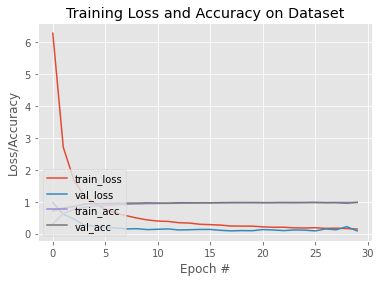

In [ ]:
# plot the training loss and accuracy
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

**Lastly we save the model for future usage.**

In [ ]:
# save the network to disk
model.save('/content/drive/MyDrive/Machine Learning/Models')